# Replicate QST article sims

### 1. RSB Hamiltonian Figure 1b

In the Fock mixtures paper, Figure 1b shows the dynamics under the RSB Hamiltonian with dissipation. The full ion trap QHO hamiltonian is:
$$
H = \frac{\Delta}{2}\sigma_{z} + \nu aa^{\dagger} + \frac{\Omega}{2}\big[\sigma^{+}D(i\eta) +\sigma^{-}D^{\dagger}(i\eta) \big]
$$

Where $D(i\eta) = e^{i\eta(a + a^{\dagger})}$ is the displacement operator. In the Lamb-Dicke regime, we can approximate this Hamiltonian to the first red sideband (RSB) interaction:
$$
H' = \frac{i\Omega\eta}{2}\big[\sigma_x(a^{\dagger} + a )\big]
$$


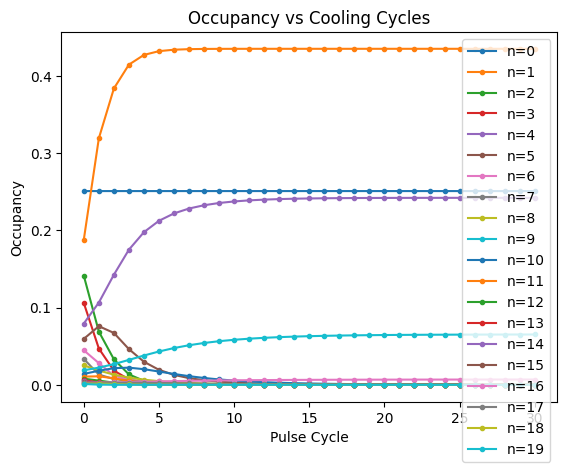

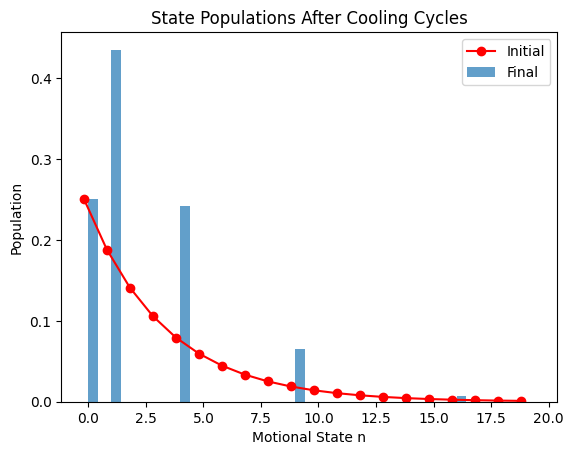

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Define system parameters
Delta = 1.0  # Detuning
nu = 1.0     # Motional frequency
Omega=.02  # Rabi frequency
eta = 0.02    # Lamb-Dicke parameter
n_thermal = 3  # Average thermal phonon number
n0 = 1
gamma = 1000  # Spin relaxation
beta = 0.01    # Inverse temperature
kT = 1.0      # Boltzmann constant times temperature
tau = 2 * np.pi / (eta * Omega * np.sqrt(n0))  # Pulse duration

# Define operators
N = 20  # Truncation for the Fock space

# QHO operators
a = destroy(N)  # Annihilation operator
a_dag = a.dag()  # Creation operator
xop = a + a_dag # Position operator

# Spin operators
sz = sigmaz()
s_plus = sigmap()
s_minus = sigmam()

# Full size operators
s_z_full = tensor(sz, qeye(N))
s_plus_full = tensor(s_plus, qeye(N))
a_full = tensor(qeye(2), a)
a_dag_full = tensor(qeye(2), a_dag)
s_minus_full = tensor(s_minus, qeye(N))

# Hamiltonian (Red Sideband for Pulse)
# H_pulse = 1j*eta*Omega/2 * (a_full* s_plus_full - a_dag_full * s_minus_full)
# Displacement operator D(i*eta)
# Note: In the paper, the argument is i*eta.
D_op = tensor(qeye(2), displace(N, 1j * eta))

# RSB Hamiltonian (Figure 1b)
H_pulse = -1j*eta*Omega/2 * (a_full* s_plus_full - a_dag_full * s_minus_full)

# Hamiltonian (Free evolution for Dissipation) - Assuming H0 during dissipation phase? 
# For now, let's assume H_diss = 0 for the dissipative step relative to the rotating frame.
H_diss = Delta*s_z_full/2 + nu*a_dag_full*a_full

# --- Collapse Operators for Dissipation with recoil ---
cosmax = 100
cosal = np.arange(-cosmax, cosmax + 1) / cosmax
W = 3 * (cosal**2 + 1) / 4 * 1 / (2 * cosmax)
W = W / np.sum(W)
G = gamma / 2  # This is Γ/2 in the master equation
tg = 2 / G  # Dissipation duration adjusted for rates
c_ops = []
for i, c in enumerate(cosal):
    U_mot = (1j * c * eta * xop).expm()
    U_full = tensor(qeye(2), U_mot)
    c_ops.append(np.sqrt(G * W[i]) * (s_minus_full * U_full))

# Add sigma_minus decay without recoil (optional, for comparison)
c_ops.append(np.sqrt(gamma) * s_minus_full)

# --- Construct Liouvillians ---
# 1. Pulse Step: Coherent RSB drive, NO dissipation (or minimal?)
# Typically only Unitary part active during pulse
L_pulse = liouvillian(H_pulse, []) 

# 2. Dissipation Step: No Drive, ONLY Dissipation (Optical Pumping)
# H = 0 (or H0), c_ops active
L_diss = liouvillian(H_diss, c_ops)

# --- Propagators ---
# Propagator for Pulse step (duration tau)
prop_pulse = (L_pulse * tau).expm()

# Propagator for Dissipation step (duration tg)
prop_diss = (L_diss * tg).expm()

# Combined Propagator for one cycle (Pulse -> Dissipation)
prop_cycle = prop_diss * prop_pulse 


# --- Simulation ---
num_pulses = 30 # Number of cycles
times_sim = np.arange(num_pulses + 1) # Just integer steps for cycles

# Initial state
rho_thermal = thermal_dm(N, n_thermal)
p_thermal = rho_thermal.diag()
ground_state = basis(2, 1) 
initial_state = tensor(ground_state * ground_state.dag(), rho_thermal)

# Storage
occupancies = np.zeros((num_pulses + 1, N))
rho_vec = operator_to_vector(initial_state)

# Initial occupancy
rho_mat = vector_to_operator(rho_vec)
occupancies[0, :] = rho_mat.ptrace(1).diag().real

# Evolve step-by-step
current_rho_vec = rho_vec
for k in range(1, num_pulses + 1):
    current_rho_vec = prop_cycle * current_rho_vec
    
    # Store
    rho_mat = vector_to_operator(current_rho_vec)
    occupancies[k, :] = rho_mat.ptrace(1).diag().real


# Plot the occupancy of all motional states over cycles
plt.figure()
for n in range(N):
    plt.plot(times_sim, occupancies[:, n], '.-', label=f'n={n}')
plt.xlabel('Pulse Cycle')
plt.ylabel('Occupancy')
plt.title('Occupancy vs Cooling Cycles')
plt.legend()
plt.show()

# Bar plot
p_motional_initial = occupancies[0, :]
p_motional_final = occupancies[-1, :]
plt.figure()
plt.plot(np.arange(N)-0.2, p_motional_initial, 'o-', label='Initial', color='red')
plt.bar(np.arange(N)+0.2, p_motional_final, width=0.4, label='Final', alpha=0.7)
plt.xlabel('Motional State n')
plt.ylabel('Population')
plt.title('State Populations After Cooling Cycles')
plt.legend()
plt.show()

### 2. Full Hamiltonian (Figures 5 and 6)

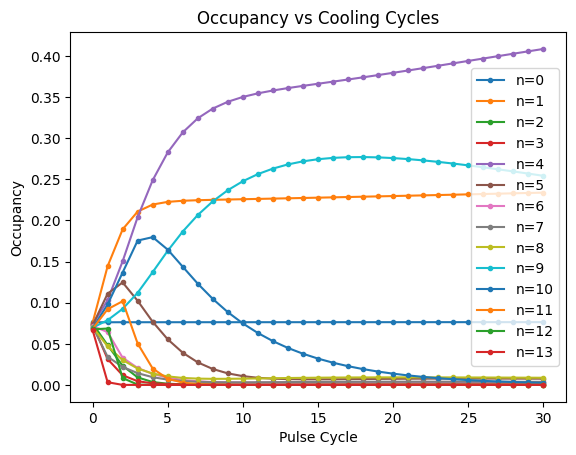

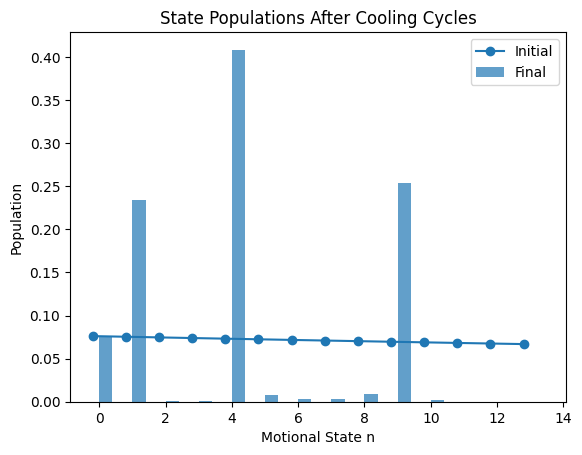

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Define system parameters
Delta = 1.0  # Detuning
nu = 1.0     # Motional frequency
Omega=.0001  # Rabi frequency
eta = 0.05    # Lamb-Dicke parameter
n_thermal = 1  # Average thermal phonon number
n0 = 1
gamma = 1000  # Spin relaxation
beta = 0.01    # Inverse temperature
kT = 1.0      # Boltzmann constant times temperature
tau = 2 * np.pi / (eta * Omega * np.sqrt(n0))  # Pulse duration

# Define operators
N = 14  # Truncation for the Fock space

# QHO operators
a = destroy(N)  # Annihilation operator
a_dag = a.dag()  # Creation operator
xop = a + a_dag # Position operator

# Spin operators
sz = sigmaz()
s_plus = sigmap()
s_minus = sigmam()

# Full size operators
s_z_full = tensor(sz, qeye(N))
s_plus_full = tensor(s_plus, qeye(N))
a_full = tensor(qeye(2), a)
a_dag_full = tensor(qeye(2), a_dag)
s_minus_full = tensor(s_minus, qeye(N))

# Displaced hamiltonian operator
D_op = tensor(qeye(2), displace(N, 1j * eta))

# Full Hamiltonian (Eq. 1)
# We set detuning Delta = nu to drive the Red Sideband
H_pulse = 0.5 * Delta * s_z_full + nu * a_dag_full * a_full + \
          0.5 * Omega * (s_plus_full * D_op + s_minus_full * D_op.dag())

# Hamiltonian (Free evolution for Dissipation)
H_diss = Delta*s_z_full/2 + nu*a_dag_full*a_full

# The density matrix in the master equation is displaced due to recoil from spontaneous emission.
# We can include this effect in the collapse operators by integrating over the angular distribution of emission
# in a dipolar transition.


# --- Collapse Operators for Dissipation with recoil ---
cosmax = 100
cosal = np.arange(-cosmax, cosmax + 1) / cosmax
W = 3 * (cosal**2 + 1) / 4 * 1 / (2 * cosmax)
W = W / np.sum(W)
G = gamma / 2  # This is Γ/2 in the master equation
tg = 2 / G  # Dissipation duration adjusted for rates
c_ops = []
for i, c in enumerate(cosal):
    U_mot = (1j * c * eta * xop).expm()
    U_full = tensor(qeye(2), U_mot)
    c_ops.append(np.sqrt(G * W[i]) * (s_minus_full * U_full))

# Add sigma_minus decay without recoil (optional, for comparison)
c_ops.append(np.sqrt(gamma) * s_minus_full)
# --- Construct Liouvillians ---
# 1. Pulse Step: Coherent RSB drive, NO dissipation (or minimal?)
# Typically only Unitary part active during pulse
L_pulse = liouvillian(H_pulse, []) 

# 2. Dissipation Step: No Drive, ONLY Dissipation (Optical Pumping)
# H = 0 (or H0), c_ops active
L_diss = liouvillian(H_diss, c_ops)

# --- Propagators ---
# Propagator for Pulse step (duration tau)
prop_pulse = (L_pulse * tau).expm()

# Propagator for Dissipation step (duration tg)
prop_diss = (L_diss * tg).expm()

# Combined Propagator for one cycle (Pulse -> Dissipation)
prop_cycle = prop_diss * prop_pulse 


# --- Simulation ---
num_pulses = 30 # Number of cycles
times_sim = np.arange(num_pulses + 1) # Just integer steps for cycles

# Initial state
thermal_state = (-beta * nu * a_dag * a / kT).expm()
thermal_state = thermal_state / thermal_state.tr() 
ground_state = basis(2, 1) 
initial_state = tensor(ground_state * ground_state.dag(), thermal_state)

# Storage
occupancies = np.zeros((num_pulses + 1, N))
rho_vec = operator_to_vector(initial_state)

# Initial occupancy
rho_mat = vector_to_operator(rho_vec)
occupancies[0, :] = rho_mat.ptrace(1).diag().real

# Evolve step-by-step
current_rho_vec = rho_vec
for k in range(1, num_pulses + 1):
    current_rho_vec = prop_cycle * current_rho_vec
    
    # Store
    rho_mat = vector_to_operator(current_rho_vec)
    occupancies[k, :] = rho_mat.ptrace(1).diag().real


# Plot the occupancy of all motional states over cycles
plt.figure()
for n in range(N):
    plt.plot(times_sim, occupancies[:, n], '.-', label=f'n={n}')
plt.xlabel('Pulse Cycle')
plt.ylabel('Occupancy')
plt.title('Occupancy vs Cooling Cycles')
plt.legend()
plt.show()

# Bar plot
p_motional_initial = occupancies[0, :]
p_motional_final = occupancies[-1, :]
plt.figure()
plt.plot(np.arange(N)-0.2, p_motional_initial, 'o-', label='Initial')
plt.bar(np.arange(N)+0.2, p_motional_final, width=0.4, label='Final', alpha=0.7)
plt.xlabel('Motional State n')
plt.ylabel('Population')
plt.title('State Populations After Cooling Cycles')
plt.legend()
plt.show()

### 3. New pulse sequence


* RF dipolar pulse to the trapped ion
* Y pulse of pi/2
* x pulse of length $\tau$
* undo y pulse
* Relacation to ground spin state
* undo displacement RF pulse

In this frame, $\Omega = \nu$ and $\Delta = 0$

Pulse duration tau: 628.3185307179587


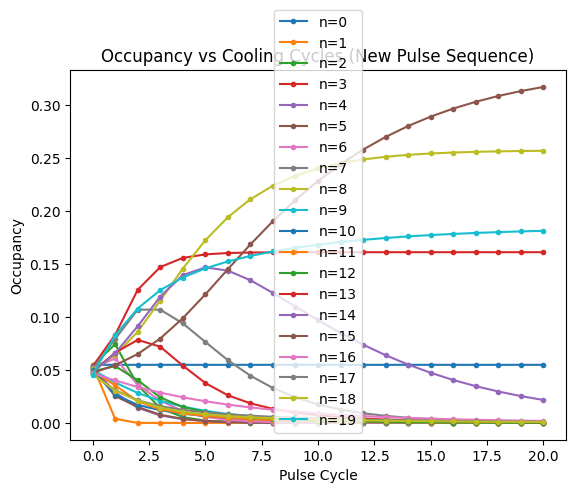

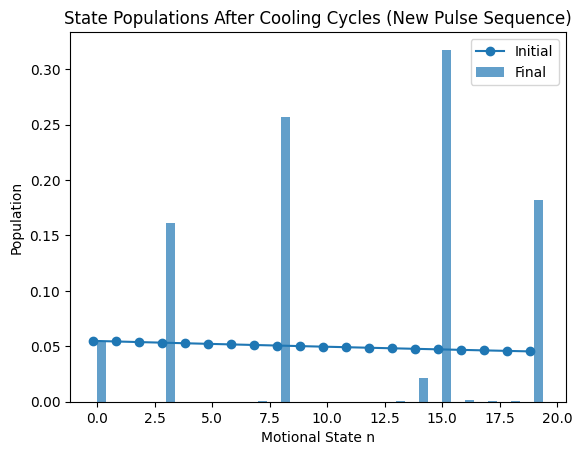

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Define system parameters
Delta = 0  # Detuning
RF_strength = 1  # RF dipolar coupling strength
nu = 1.0     # Motional frequency
Omega = nu  # Rabi frequency
Omega_y = 1*Omega  # Rabi frequency for Y pulse
eta = 0.01    # Lamb-Dicke parameter
n_thermal = 1  # Average thermal phonon number
n0 = 1
gamma = 1000  # Spin relaxation
beta = 0.01    # Inverse temperature
kT = 1.0      # Boltzmann constant times temperature
tau = 2 * np.pi / (eta * Omega * np.sqrt(n0))  # Pulse duration
print(f"Pulse duration tau: {tau}")
# Define operators
N = 20  # Truncation for the Fock space

# QHO operators
a = destroy(N)  # Annihilation operator
a_dag = a.dag()  # Creation operator
xop = a + a_dag  # Position operator

# Spin operators
sz = sigmaz()
s_plus = sigmap()
s_minus = sigmam()
s_y = sigmay()
s_x = sigmax()

# Full size operators
s_z_full = tensor(sz, qeye(N))
s_plus_full = tensor(s_plus, qeye(N))
s_minus_full = tensor(s_minus, qeye(N))
s_y_full = tensor(s_y, qeye(N))
a_full = tensor(qeye(2), a)
a_dag_full = tensor(qeye(2), a_dag)
s_minus_full = tensor(s_minus, qeye(N))
s_x_full = tensor(s_x, qeye(N))

# Displaced Hamiltonian operator
D_op = tensor(qeye(2), displace(N, 1j * eta))

"""Hamiltonians for pulse and dissipation steps defined above."""

# Hamiltonian (Free evolution for Dissipation)
H_diss = Delta * s_z_full / 2 + nu * a_dag_full * a_full

# --- Pulses for the new sequence ---

# 1) RF dipolar pulse of i*eta/2
H_rf = (RF_strength / 2) * (a_full + a_dag_full)
rf_duration = eta / RF_strength
L_rf = liouvillian(H_rf, [])
prop_rf = (L_rf * rf_duration).expm()
# undo RF
prop_rf_undo = (-L_rf * rf_duration).expm()
 
# 2) Y(π/2) pulse on the spin, same as H_pulse but with phase shift on the sigmas
H_y = 0.5 * Delta * s_z_full + nu * a_dag_full * a_full + \
          0.5 * Omega_y * (1j * s_plus_full * D_op - 1j * s_minus_full * D_op.dag())
y_duration = np.pi / (2 *Omega_y)
L_y = liouvillian(H_y, [])
prop_y = (L_y * y_duration).expm()
# Undo Y(π/2)
L_y_undo = liouvillian(-H_y, [])
prop_y_undo = (L_y_undo * y_duration).expm()
 
 
# 3) X(τ) pulse on the spin, same as H_pulse but with different phase
H_x = 0.5 * Delta * s_z_full + nu * a_dag_full * a_full + \
          0.5 * Omega * (s_plus_full * D_op + s_minus_full * D_op.dag())
L_x = liouvillian(H_x, [])
prop_x = (L_x * tau).expm()

# --- Collapse Operators for Dissipation with recoil ---
cosmax = 100
cosal = np.arange(-cosmax, cosmax + 1) / cosmax
W = 3 * (cosal**2 + 1) / 4 * 1 / (2 * cosmax)
W = W / np.sum(W)
G = gamma / 2  # This is Γ/2 in the master equation
tg = 2 / G  # Dissipation duration adjusted for rates
c_ops = []
for i, c in enumerate(cosal):
    U_mot = (1j * c * eta * xop).expm()
    U_full = tensor(qeye(2), U_mot)
    c_ops.append(np.sqrt(G * W[i]) * (s_minus_full * U_full))

# Add sigma_minus decay without recoil (optional, for comparison)
c_ops.append(np.sqrt(gamma) * s_minus_full)

# --- Liouvillian and propagator for dissipation step ---
L_diss = liouvillian(H_diss, c_ops)
prop_diss = (L_diss * tg).expm()

# Combined Propagator for one cooling cycle:
## RF dipolar pulse -> Y(π/2) -> X(τ) -> undo Y -> relaxation -> undo RF
prop_cycle = prop_diss * prop_rf_undo * prop_y_undo * prop_x * prop_y * prop_rf
# prop_cycle = prop_rf_undo * prop_diss * prop_y_undo * prop_x * prop_y * prop_rf

# Test whether D_op.dag is equivalent to H_rf
# L_D_op = liouvillian(D_op.dag(), [])
# prop_D_op_full = (L_D_op ).expm()
# prop_undo_D_op_full = ( L_D_op ).expm()
# prop_cycle =  prop_diss * prop_y_undo * prop_x * prop_y * prop_D_op_full.dag()

# # Now test with a ground state initial condition
# mot_vac = basis(N, 0)
# spin_g = basis(2, 0)
# psi_test = tensor(spin_g, mot_vac)

# # Convert state to vector form for Liouvillian propagator
# psi_test_vec = operator_to_vector(psi_test * psi_test.dag())

# psi_D_vec  = prop_cycle_test * psi_test_vec
# psi_normal_vec = prop_cycle * psi_test_vec

# # Convert back to operator form
# psi_D = vector_to_operator(psi_D_vec)
# psi_normal = vector_to_operator(psi_normal_vec)

# # Verify equivalence
# diff_norm = (prop_cycle_test - prop_cycle).norm()
# print(f"Norm difference between both implementations of the cycle propagator: {diff_norm}")

# overlap = (psi_D * psi_normal).tr()
# print(f"Overlap between both implementations on ground state: {overlap}")


# --- Simulation ---
num_pulses = 20  # Number of cycles
times_sim = np.arange(num_pulses + 1)  # Integer steps for cycles

# Initial state: spin in ground, motion thermal
thermal_state = (-beta * nu * a_dag * a / kT).expm()
thermal_state = thermal_state / thermal_state.tr()
ground_state = basis(2, 1)
initial_state = tensor(ground_state * ground_state.dag(), thermal_state)

# Storage
occupancies = np.zeros((num_pulses + 1, N))
rho_vec = operator_to_vector(initial_state)

# Initial occupancy
rho_mat = vector_to_operator(rho_vec)
occupancies[0, :] = rho_mat.ptrace(1).diag().real

# Evolve step-by-step under the new pulse sequence
current_rho_vec = rho_vec
for k in range(1, num_pulses + 1):
    current_rho_vec = prop_cycle * current_rho_vec

    # Store
    rho_mat = vector_to_operator(current_rho_vec)
    occupancies[k, :] = rho_mat.ptrace(1).diag().real


# Plot the occupancy of all motional states over cycles
plt.figure()
for n in range(N):
    plt.plot(times_sim, occupancies[:, n], '.-', label=f'n={n}')
plt.xlabel('Pulse Cycle')
plt.ylabel('Occupancy')
plt.title('Occupancy vs Cooling Cycles (New Pulse Sequence)')
plt.legend()
plt.show()

# Bar plot
p_motional_initial = occupancies[0, :]
p_motional_final = occupancies[-1, :]
plt.figure()
plt.plot(np.arange(N) - 0.2, p_motional_initial, 'o-', label='Initial')
plt.bar(np.arange(N) + 0.2, p_motional_final, width=0.4, label='Final', alpha=0.7)
plt.xlabel('Motional State n')
plt.ylabel('Population')
plt.title('State Populations After Cooling Cycles (New Pulse Sequence)')
plt.legend()
plt.show()